
Задача сегментации окурков на изображении.
---



Для начала, установим необходимые пакеты. Из них: 

*   [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) - набор основных энкодеров/декодеров для задач семантической сегментации
*   [pytorch_toolbelt](https://github.com/BloodAxe/pytorch-toolbelt) - пакет с множеством различных функций потерь
*   [albumentations](https://github.com/albumentations-team/albumentations) - для аугментаций
*   [Pytorch lightning](https://github.com/PyTorchLightning/pytorch-lightning) - для абстракции трейн / валидационных циклов
*   [TTach](https://github.com/qubvel/ttach) - для test-time augmentations



In [1]:
!pip install segmentation-models-pytorch
!pip install pytorch_toolbelt
! pip install albumentations==0.4.6
!pip install pytorch_lightning
!pip install ttach

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 163kB 10.9MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=41fbcb8dc9ec85b56a91f9a1e10a46ccf915399957f9cebc158d2052a31909cb
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60964 sha256=150aa03e4f463bf9840147e89cef972bf2284b82bda0a58cc3d094db4d676b2d
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels
     |████████████████████████████████| 102kB 3.9MB/s 
     |████████████████████████████████| 686kB 7.4MB/s 
     |████████████████████████████████| 204kB 12.4MB/s 
  Created wheel for pytorch-toolbelt: filename=py

Подключение гугл диска, для доступа к данным и записи чекпоинтов.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import json
from torch.utils.data import Dataset as BaseDataset
import cv2
import numpy as np
from pytorch_toolbelt import losses as L
from pytorch_lightning.callbacks import ModelCheckpoint
from glob import glob
from google.colab.patches import cv2_imshow
import albumentations as albu
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
import ttach as tta

torch.cuda.set_device(0)
!export CUDA_LAUNCH_BLOCKING=1

Реализуем класс Dataset для чтения изображений, масок и применения аугментаций 

In [7]:
class CigaretteDataset(BaseDataset):
    """CigaretteDataset Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        directory (str): path to images folder
      
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)
        json_path (str): path to json anntotation file

    """

    def __init__(
            self,
            directory,
            json_path = None,
            augmentation=None,
            post_transforms=None,
    ):  

        self.directory = directory
        with open(json_path) as json_data:
              self.data = json.load(json_data)


        self.augmentation = augmentation
        self.post_transforms = post_transforms

    def __getitem__(self, i):

        image_path = os.path.join(self.directory, self.data['images'][i]['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # mask = decode_rle(str(self.data['annotations'][i]['segmentation']))
        mask = np.zeros((512, 512)).astype(np.uint8)
        polygon = np.array(self.data['annotations'][i]['segmentation']).reshape((-1, 2))
        mask = cv2.fillPoly(mask, [polygon.astype(np.int32)], color=1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        image = image / 255
        if self.post_transforms:
            sample = self.post_transforms(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        # image = image / 255
        return image, mask

    def __len__(self):
        return len(self.data['images'])

На основе модуля pytorch lightning и segmenation models реализуем модель. Для первого эксперимента будем использовать Unet с энкодером ResNet-50 и базовыми аугментациями: вертикальные флипы, горизонтальные флипы и ShiftScaleRotate.

* Оптимизатор: Adam
* Функция потерь: Dice loss
* LR scheduler: CosineAnnealingLR

In [8]:
class CigaretteUnet(pl.LightningModule):
  # """
  #   Semantic Segmentation Module
  #   This is a basic semantic segmentation module implemented with Lightning.
  #   It uses CrossEntropyLoss as the default loss function. May be replaced with
  #   other loss functions as required.
  #   Adam optimizer is used along with Cosine Annealing learning rate scheduler.
  #   """

    def __init__(self, 
                 trainset,
                 valset,
                 encoder: str,
                 encoder_weights: str,
                 activation: str,
                 batch_size: int,
                 lr: float):
        super(CigaretteUnet, self).__init__()
        self.trainset = trainset
        self.valset = valset
        self.encoder = encoder
        self.encoder_weights = encoder_weights
        self.activation = activation
        self.batch_size = batch_size
        self.learning_rate = lr
        
        # self.trainset = CigaretteDataset(directory = os.path.join(self.directory, 'train'), post_transforms = self.post_transforms)
        # self.valset = CigaretteDataset(directory = os.path.join(self.directory, 'val'), post_transforms = self.post_transforms)
        

        self.net = smp.Unet(
            encoder_name = self.encoder,
            encoder_weights = self.encoder_weights,
            classes=1,
            activation = self.activation
            )
        
        
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_nb) :
        img, mask = batch
        img = img.float()
        mask = mask.long()
        out = self.forward(img)
        loss = L.DiceLoss(mode = 'binary')
        loss_val = loss(out, mask.unsqueeze(1))

        return {'loss' : loss_val}

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        img = img.float()
        mask = mask.long()
        out = self(img)
        loss = L.DiceLoss(mode = 'binary')
        loss_val = loss(out, mask)
        dice_val = dice(out.squeeze(1).squeeze(0), mask.squeeze(0))
        return {'val_loss': loss_val, 
                'dice_metric': dice_val
                }

    def validation_epoch_end(self, outputs):
        loss_val = torch.stack([x['val_loss'] for x in outputs]).mean()
        dice_val = torch.stack([x['dice_metric'] for x in outputs]).sum().float()
        dice_val /= len(outputs)
        log_dict = {'val_loss': loss_val, 'dice_score': dice_val}
        # log_dict = {}
        return {'log': log_dict, 'val_loss': log_dict['val_loss'], 'dice_score': log_dict['dice_score'], 'progress_bar': log_dict}
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr = self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max = 15)
        return [opt], [sch]
    
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size = self.batch_size, shuffle = True)
    
    def val_dataloader(self):
        return DataLoader(self.valset, batch_size = 1, shuffle = False)

Аугментации: вертикальные флипы, горизонтальные флипы и ShiftScaleRotate.

In [9]:
hard_transforms = albu.Compose([
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=40, shift_limit=0.1, p=0.5, border_mode=2),
              ])  
post_transforms = albu.Compose([
        ToTensorV2()
    ])

Метрика Dice

In [10]:
EPS = 1e-10
def dice(pred, targs):
    pred = (pred>0).float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + EPS)

Иницилизация трейн/валидационного датасетов и модели.

In [11]:
trainset = CigaretteDataset(directory = '/content/drive/My Drive/cigarette_butt_segmentation/data/train/images/', 
                            json_path ='/content/drive/My Drive/cigarette_butt_segmentation/data/train/coco_annotations.json',
                            augmentation = hard_transforms, 
                            post_transforms = post_transforms)
valset = CigaretteDataset(directory = '/content/drive/My Drive/cigarette_butt_segmentation/data/val/images/', 
                          json_path = '/content/drive/My Drive/cigarette_butt_segmentation/data/val/coco_annotations.json', 
                          post_transforms = post_transforms)

model = CigaretteUnet(trainset = trainset,
                      valset = valset,
                      encoder = 'resnet50',
                      encoder_weights = 'imagenet',
                      activation = None,
                      batch_size = 16,
                      lr = 1e-4)

Для сохранение лучшего чекпоинта будем ипользовать колбэк, который будет мониторить значение dice метрики на валидационной выборке. 

Количество эпох: 15

In [9]:
checkpoint_callback = ModelCheckpoint(filepath='/content/drive/My Drive/cigarette_butt_segmentation/logs/resnet50_unet/{epoch}-{dice_score:.2f}', 
                                      monitor = 'dice_score',
                                      mode='max')
trainer = pl.Trainer(
        gpus=1,
        max_epochs=15,
        checkpoint_callback=checkpoint_callback
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Обучение модели

In [10]:
trainer.fit(model = model)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name | Type | Params
------------------------------
0 | net  | Unet | 32 M  


Saving latest checkpoint..


1

Проверим значение метрики, используя функцию из lib/metrics.py 

In [15]:
def dice_score(true, pred):
    """Dice score.

    Parameters
    ----------
    true : np.ndarray, 2d
         Ground truth mask that consists of 2 unique values: 0 - denotes background,
         1 - denotes object.
    pred : np.ndarray, 2d
         Predicted mask that consists of 2 unique values: 0 - denotes background,
         1 - denotes object.

    Returns
    -------
    float from 0 to 1
        Dice score. The greater the value of dice score the better.

    Notes
    -----
    Masks should contains only 2 unique values, one of them must be 0, another value, that denotes
    object, could be different from 1 (for example 255).

    """
    true = true.astype(bool)
    pred = pred.astype(bool)

    intersection = (true & pred).sum()
    im_sum = true.sum() + pred.sum()

    return 2.0 * intersection / (im_sum + EPS)

In [16]:
device = torch.device('cuda')
checkpoint = torch.load('/content/drive/My Drive/cigarette_butt_segmentation/logs/resnet50_unet/epoch=12-dice_score=0.96.ckpt', map_location = device)
model.load_state_dict(checkpoint['state_dict'])
val_loader = DataLoader(valset, batch_size = 1, shuffle = False)
model.to(device)
model.eval()

score=[]

for image, gt_mask in val_loader:
  pred_mask = model(image.to(device).float()
  pred_mask = (pred_mask>0).float()
  score.append(dice_score(gt_mask.squeeze(0).squeeze(0).cpu().detach().numpy(), pred_mask.squeeze(0).squeeze(0).cpu().detach().numpy().astype(int)))
  
print(np.mean(score))

0.9591613761859472


Полученое значение: 0.9591613761859472. Пара примеров Ground truth(слева) и предиктов(справа), для визуальной оценки. 

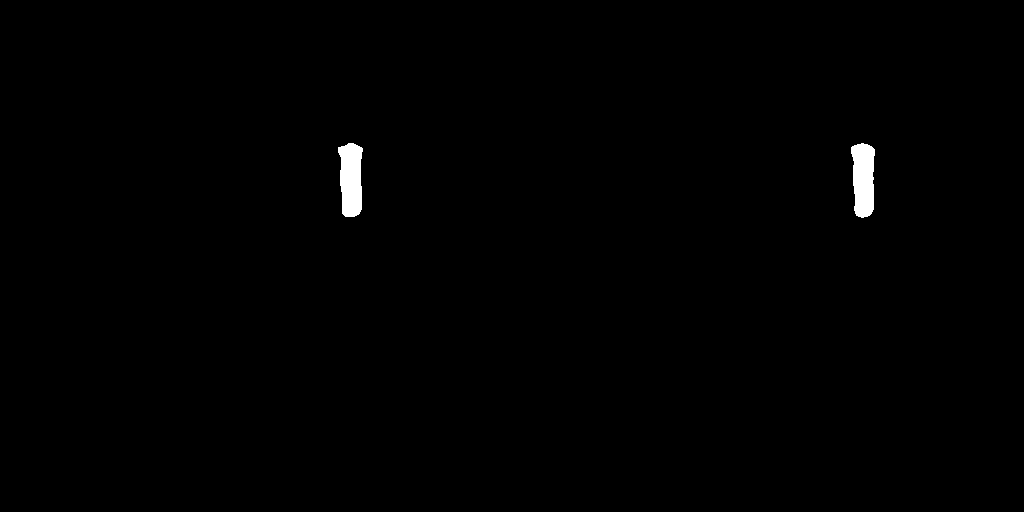

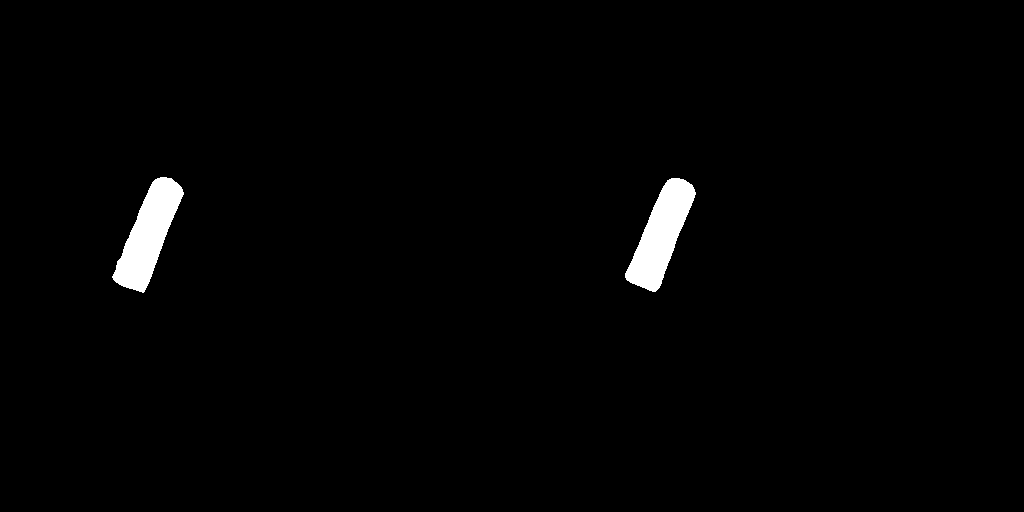

In [17]:
dataloader_iterator = iter(val_loader)

for i in range(2):
  image, gt_mask = next(dataloader_iterator)
  pred_mask = model(image.to(device).float())
  pred_mask = (pred_mask>0).float()
  cv2_imshow(np.hstack((gt_mask.squeeze(0).cpu().detach().numpy()*255, pred_mask.squeeze(0).squeeze(0).cpu().detach().numpy()*255)))




Попробуем применить TTA и посмотреть улучшит ли это значение метрики Dice

In [18]:
tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')

score=[]
for image, gt_mask in val_loader:
  pred_mask = tta_model(image.to(device).float())
  pred_mask = (pred_mask>0).float()
  score.append(dice_score(gt_mask.squeeze(0).squeeze(0).cpu().detach().numpy(), pred_mask.squeeze(0).squeeze(0).cpu().detach().numpy().astype(int)))
  
print(np.mean(score))


0.9616489050894979


TTA позволило немного улучшить значение метрики до 0.9616489050894979

Теперь попробуем обучить другую модель, на основе декодера DeepLabV3+

In [34]:
class CigaretteDeeplab(pl.LightningModule):
  # """
  #   Semantic Segmentation Module
  #   This is a basic semantic segmentation module implemented with Lightning.
  #   It uses CrossEntropyLoss as the default loss function. May be replaced with
  #   other loss functions as required.
  #   Adam optimizer is used along with Cosine Annealing learning rate scheduler.
  #   """

    def __init__(self, 
                 trainset,
                 valset,
                 encoder: str,
                 encoder_weights: str,
                 activation: str,
                 batch_size: int,
                 lr: float):
        super(CigaretteDeeplab, self).__init__()
        self.trainset = trainset
        self.valset = valset
        self.encoder = encoder
        self.encoder_weights = encoder_weights
        self.activation = activation
        self.batch_size = batch_size
        self.learning_rate = lr
        

        self.net = smp.DeepLabV3Plus(
            encoder_name = self.encoder,
            encoder_weights = self.encoder_weights,
            classes=1,
            activation = self.activation
            )
        
        
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_nb) :
        img, mask = batch
        img = img.float()
        mask = mask.long()
        out = self.forward(img)
        loss = L.DiceLoss(mode = 'binary')
        loss_val = loss(out, mask.unsqueeze(1))

        return {'loss' : loss_val}

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        img = img.float()
        mask = mask.long()
        out = self(img)
        loss = L.DiceLoss(mode = 'binary')
        loss_val = loss(out, mask)
        dice_val = dice(out.squeeze(1).squeeze(0), mask.squeeze(0))
        return {'val_loss': loss_val, 
                'dice_metric': dice_val
                }

    def validation_epoch_end(self, outputs):
        loss_val = torch.stack([x['val_loss'] for x in outputs]).mean()
        dice_val = torch.stack([x['dice_metric'] for x in outputs]).sum().float()
        dice_val /= len(outputs)
        log_dict = {'val_loss': loss_val, 'dice_score': dice_val}
        # log_dict = {}
        return {'log': log_dict, 'val_loss': log_dict['val_loss'], 'dice_score': log_dict['dice_score'], 'progress_bar': log_dict}
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr = self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max = 15)
        return [opt], [sch]
    
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size = self.batch_size, shuffle = True)
    
    def val_dataloader(self):
        return DataLoader(self.valset, batch_size = 1, shuffle = False)

In [35]:
model = CigaretteDeeplab(trainset = trainset,
                      valset = valset,
                      encoder = 'resnet50',
                      encoder_weights = 'imagenet',
                      activation = None,
                      batch_size = 16,
                      lr = 1e-4)

In [23]:
checkpoint_callback = ModelCheckpoint(filepath='/content/drive/My Drive/cigarette_butt_segmentation/logs/resnet50_deepalab/{epoch}-{dice_score:.2f}', 
                                      monitor = 'dice_score',
                                      mode='max')
trainer = pl.Trainer(
        gpus=1,
        max_epochs=15,
        checkpoint_callback=checkpoint_callback
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [24]:
trainer.fit(model = model)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name | Type          | Params
---------------------------------------
0 | net  | DeepLabV3Plus | 26 M  


Saving latest checkpoint..


1

Проверяем значение метрики

In [38]:
checkpoint = torch.load('/content/drive/My Drive/cigarette_butt_segmentation/logs/resnet50_deepalab/epoch=11-dice_score=0.95.ckpt', map_location = device)
model.load_state_dict(checkpoint['state_dict'])
val_loader = DataLoader(valset, batch_size = 1, shuffle = False)
model.to(device)
model.eval()

score=[]

for image, gt_mask in val_loader:
  pred_mask = model(image.to(device).float())
  pred_mask = (pred_mask>0).float()
  score.append(dice_score(gt_mask.squeeze(0).squeeze(0).cpu().detach().numpy(), pred_mask.squeeze(0).squeeze(0).cpu().detach().numpy().astype(int)))
  
print(np.mean(score))

0.9529715496192718


Архитектура с Deeplab декодером показывает результат хуже. Поэтому для финального результата будем использовать Resnet-50 Unet c TTA

Запишем предикты лучшей модели на валидационной выборке в pred_val.csv

In [19]:
def encode_rle(mask):
    """Returns encoded mask (run length) as a string.

    Parameters
    ----------
    mask : np.ndarray, 2d
        Mask that consists of 2 unique values: 0 - denotes background, 1 - denotes object.

    Returns
    -------
    str
        Encoded mask.

    Notes
    -----
    Mask should contains only 2 unique values, one of them must be 0, another value, that denotes
    object, could be different from 1 (for example 255).

    """
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]

    return ' '.join(str(x) for x in runs)

In [21]:
checkpoint = torch.load('/content/drive/My Drive/cigarette_butt_segmentation/logs/resnet50_unet/epoch=12-dice_score=0.96.ckpt', map_location = device)
model = CigaretteUnet(trainset = trainset,
                      valset = valset,
                      encoder = 'resnet50',
                      encoder_weights = 'imagenet',
                      activation = None,
                      batch_size = 16,
                      lr = 1e-4)
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')

template_csv = pd.read_csv("/content/drive/My Drive/cigarette_butt_segmentation/pred_val_template.csv")
# val_folder = '/content/drive/My Drive/cigarette_butt_segmentation/val/'
results = []
paths_to_imgs = sorted(glob("/content/drive/My Drive/cigarette_butt_segmentation/data/val/images/*"))

for path in paths_to_imgs:
  # print(path)
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255

  sample = post_transforms(image = image)
  image = sample['image'].float()
  

  pred_mask = tta_model(image.unsqueeze(0).to(device))
  pred_mask = (pred_mask>0).float()

  result = {
        'id': int(path.split("/")[-1].split(".")[0]),
        'rle_mask': encode_rle(pred_mask.squeeze(0).squeeze(0).cpu().detach().numpy().astype(int)),
    }

  results.append(result)
  
pred_csv = pd.DataFrame(results)
pred_csv.to_csv('/content/drive/My Drive/cigarette_butt_segmentation/pred_val.csv', index=False)



Теперь сделаем инференс на изображениях из real_test и сделаем из этого html страницу

In [22]:
def generate_html(path_to_data):
    """Generates content of html file and saves it.

    Parameters
    ----------
    path_to_data : str
        Path to data with original images, predicted masks, and cropped according masks images.

    Returns
    -------
    str
        Content of html file.

    """
    html = "\n".join(["<!doctype html>", "<html>", "<head>",
                      "<meta http-equiv='Content-Type' content='text/html; charset=utf-8'>",
                      "<title>Визуализация результатов</title>", "</head>", "<body>",
                      "<table cellspacing='0' cellpadding='5'>"]) + "\n"
    paths_to_imgs = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_img.jpg")])
    paths_to_masks = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_pred_mask.png")])
    paths_to_crops = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_crop.png")])
    for ind, (path_to_img, path_to_mask, path_to_crop) in enumerate(zip(paths_to_imgs,
                                                                        paths_to_masks,
                                                                        paths_to_crops)):
        if not ind % 2:
            html += "<tr>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_img}'"
        html += "alt='Something went wrong.'"
        html += f"height='320' title='Original image:\n{path_to_img}'></td>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_mask}'"
        html += "alt='Something went wrong.'"
        html += "height='320' title='Predicted mask'></td>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_crop}'"
        html += "alt='Something went wrong.'"
        html += "height='320' title='Cropped img according\npredicted mask'></td>\n"
        if not ind % 2:
            html += "<td width='100'></td>\n"
        else:
            html += "</tr>\n"
    date = datetime.today().strftime("%Y-%m-%d-%H.%M.%S")
    html += f"</table>\n<i>The page was generated at {date}</i></body>\n</html>"
    filename = os.path.basename(path_to_data) + ".html"
    path_to_save = os.path.dirname(path_to_data)
    with open(f"{path_to_save}/{filename}", "w") as f:
        f.write(html)

    return html


def get_html(paths_to_imgs, pred_masks, path_to_save="results/test"):
    """Generates html file and saves it.

    Parameters
    ----------
    paths_to_imgs : list[str]
        List of paths to original images.
    pred_masks : list[np.ndarray]
        Predicted masks.
    path_to_save : str
        Path to save source images to put them in html file. Html name is the same as name of the
        last folder on `path_to_save` and is saved on upper level.

    Returns
    -------
    str
        Content of html file.

    """
    paths_to_imgs = np.array(paths_to_imgs)
    pred_masks = np.array(pred_masks)

    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)

    order = np.argsort(paths_to_imgs)
    paths_to_imgs = paths_to_imgs[order]
    pred_masks = pred_masks[order]

    for path_to_img, pred_mask in zip(paths_to_imgs, pred_masks):
        img_id = path_to_img.split("/")[-1].split(".")[0]
        img = np.array(Image.open(path_to_img))[:, :, :3]
        Image.fromarray(img).save(f"{path_to_save}/{img_id}_img.jpg")
        Image.fromarray(pred_mask).save(f"{path_to_save}/{img_id}_pred_mask.png")
        crop_img = img.copy()
        crop_img[pred_mask == 0] = 0
        Image.fromarray(crop_img).save(f"{path_to_save}/{img_id}_crop.png")

    html = generate_html(path_to_save)

    return html

In [33]:
paths_to_imgs = sorted(glob("/content/drive/My Drive/cigarette_butt_segmentation/data/real_test/*"))
pred_masks = []
for path in paths_to_imgs:
  print(path)
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255

  sample = post_transforms(image = image)
  image = sample['image'].float()
  

  pred_mask = tta_model(image.unsqueeze(0).to(device))
  pred_mask = (pred_mask>0)

  pred_masks.append(np.asarray(pred_mask.squeeze(0).squeeze(0).cpu().detach().numpy()))

_ = get_html(paths_to_imgs, pred_masks, path_to_save="/content/drive/My Drive/cigarette_butt_segmentation/results/example")

/content/drive/My Drive/cigarette_butt_segmentation/data/real_test/0000.JPG
/content/drive/My Drive/cigarette_butt_segmentation/data/real_test/0001.JPG
/content/drive/My Drive/cigarette_butt_segmentation/data/real_test/0002.JPG
/content/drive/My Drive/cigarette_butt_segmentation/data/real_test/0003.JPG
/content/drive/My Drive/cigarette_butt_segmentation/data/real_test/0004.JPG
/content/drive/My Drive/cigarette_butt_segmentation/data/real_test/0005.JPG
/content/drive/My Drive/cigarette_butt_segmentation/data/real_test/0006.JPG
/content/drive/My Drive/cigarette_butt_segmentation/data/real_test/0007.JPG
/content/drive/My Drive/cigarette_butt_segmentation/data/real_test/0008.JPG
/content/drive/My Drive/cigarette_butt_segmentation/data/real_test/0009.JPG


В ходе экспериментов было выявлено, что лучший результат выдает 

Для дальнейших экспериментов было бы интересно протестировать:
 
*  различные энкодеры(например efficientnet) и 
*  подобрать аугментации.
Также поэксперементировать с loss функциями, например, focal loss, lovazh-hinge loss.